In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp '/content/drive/MyDrive/Datasets/Dataset A.zip'  './'

In [ ]:
!unzip '/content/Dataset A.zip'

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
data=pd.read_csv('/content/training-a.csv')
data

,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a
...,...,...,...,...,...,...,...
19697,a19697.png,Scan_81_digit_4_num_3.png,81,4,BHDDB,Buet_Broncos,training-a
19698,a19698.png,Scan_70_digit_3_num_6.png,70,3,BHDDB,Buet_Broncos,training-a
19699,a19699.png,Scan_253_digit_8_num_4.png,253,8,BHDDB,Buet_Broncos,training-a
19700,a19700.png,Scan_27_digit_3_num_6.png,27,3,BHDDB,Buet_Broncos,training-a


In [6]:
import torch
import cv2
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from PIL import ImageFile,Image
from skimage import io, transform
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch.nn as nn
import torch.nn.functional as f
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 

In [7]:
IMAGE_SIZE = 64
transform = transforms.Compose([
    transforms.ToPILImage(),
    torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
    transforms.RandomRotation(20,expand=True), 
    transforms.Resize(IMAGE_SIZE),  ## image resize
    transforms.CenterCrop(IMAGE_SIZE), ## image center crop
    transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [8]:
class digit_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=True):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
   
    def __len__(self):
         return len(self.annotations)

        
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 3]))

        if self.transform:
            image = self.transform(image)
        return (image, y_label)


In [9]:
dataset =digit_Dataset(   
    csv_file=   "/content/training-a.csv", 

    root_dir= "/content/training-a",  
    transform=transform,
)

In [10]:
train_set, test_set = torch.utils.data.random_split(dataset, [15702, 4000])
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=True)

In [11]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
images.shape


torch.Size([32, 3, 64, 64])

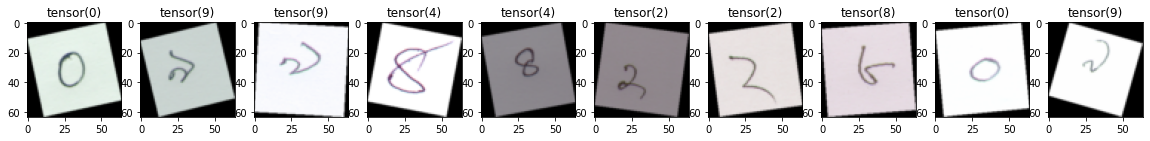

In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next() 
plt.subplots(figsize=(20, 32))
for i in range(10):
    plt.subplot(10/2, 10,i+1)
    img = images[i].detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5]) 
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.title(labels[i])
    # print(img.shape)
    plt.imshow(img)
plt.show()


In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
class Net(nn.Module): # Module is library package
    
    def __init__(self):
        super().__init__()
        
        self.fc1=nn.Linear(3*64 * 64, 200)  #flatten the image 
        self.fc2=nn.Linear(200,200)
        self.fc3=nn.Linear(200,200)
        self.fc4=nn.Linear(200,200)  
        self.fc5=nn.Linear(200,10)
        #self.fc6=nn.Linear(200,10)
        
    def forward(self,x): # pass the data
        
        x=f.relu(self.fc1(x))
        x=f.relu(self.fc2(x))
        x=f.relu(self.fc3(x))
        x=f.relu(self.fc4(x))
        #x=f.relu(self.fc5(x))
        x = self.fc5(x)
        
        return x

net = Net().to(device)
net

Net(
  (fc1): Linear(in_features=12288, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=10, bias=True)
)

In [16]:
optimizer =  optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [17]:
Path='./net_final.pth'
traininglosses = []
trainingaccuracy = []
testinglosses = []
testaccuracy = []
totalsteps = []
epochs = 90
steps = 0
running_loss = 0
print_every = 4000

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        net.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 
        
        logps = net.forward(inputs.view(-1,3*64*64))
        loss = criterion(logps, labels)
        loss.backward() 
        optimizer.step() 

        
                #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            test_loss = 0
            accuracy = 0
            net.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = net.forward(inputs.view(-1,3*64*64))
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            traininglosses.append(running_loss/print_every)
            trainingaccuracy.append(after_train_accuracy)
            testinglosses.append(test_loss/len(test_loader))
            testaccuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Step {steps} "
                  f"Train loss: {running_loss/print_every:f} "
                  f"Train accuracy: {after_train_accuracy:f} "
                  f"Test loss: {test_loss/len(test_loader):f} "
                  f"Test accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            net.train()
print('Finish Train')
torch.save(net.state_dict(), Path)

Device cpu Epoch 9/90 Step 4000 Train loss: 2.295628 Train accuracy: 0.003195 Test loss: 2.257405 Test accuracy: 0.199000
Device cpu Epoch 17/90 Step 8000 Train loss: 2.080589 Train accuracy: 0.011867 Test loss: 1.899717 Test accuracy: 0.334000
Device cpu Epoch 25/90 Step 12000 Train loss: 1.712288 Train accuracy: 0.024508 Test loss: 1.622411 Test accuracy: 0.439250
Device cpu Epoch 33/90 Step 16000 Train loss: 1.469082 Train accuracy: 0.037109 Test loss: 1.319204 Test accuracy: 0.550250
Device cpu Epoch 41/90 Step 20000 Train loss: 1.313379 Train accuracy: 0.050766 Test loss: 1.285632 Test accuracy: 0.550250
Device cpu Epoch 49/90 Step 24000 Train loss: 1.189776 Train accuracy: 0.066078 Test loss: 1.194709 Test accuracy: 0.588500
Device cpu Epoch 58/90 Step 28000 Train loss: 1.070168 Train accuracy: 0.002164 Test loss: 1.019029 Test accuracy: 0.655500
Device cpu Epoch 66/90 Step 32000 Train loss: 0.947967 Train accuracy: 0.014680 Test loss: 0.923825 Test accuracy: 0.690000
Device cpu 

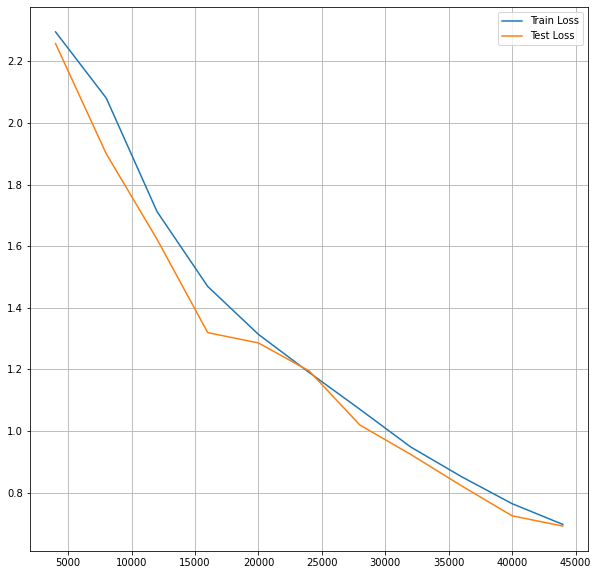

In [18]:
plt.figure(figsize=(10, 10))
plt.plot(totalsteps, traininglosses, label='Train Loss')
plt.plot(totalsteps, testinglosses, label='Test Loss')

plt.legend()
plt.grid()
plt.show()

In [19]:
correct=0
total=0
with torch.no_grad():
    for data in test_loader:
        X,y=data
        X, y = X.to(device), y.to(device)
        
        output=net(X.view(-1,3*64*64))
        for idx, i in enumerate(output):
            if torch.argmax(i)==y[idx]:
                correct+=1
            total+=1
            
print(round(correct/total,3))

0.773
